In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data 
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import glob
import natsort
import numpy as np
import imageio
import torchvision
import matplotlib as mpl
import matplotlib.pyplot as plt
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import h5py
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from colorspacious import cspace_converter
from matplotlib import cm
import random

In [2]:
hf = h5py.File(r"Dataset/Brats2018_validation_data_sep_channels_train_val_mix.h5", 'r')
val_data = hf['data'][()]     #`data` is now an ndarray
val_data_tensor = torch.from_numpy(val_data).float()

hf.close()

hf_val = h5py.File(r"Dataset/binary_mask_val.h5", 'r')
binary_mask_t1ce = hf_val['binary_mask_val_closed'][()]
binary_mask_t1ce = torch.from_numpy(binary_mask_t1ce).float().to(device)

hf_val.close()

for i in range(len(val_data)):
    for j in range(4):
        val_data[i,j,:,:] = (val_data[i,j,:,:] - np.min(val_data[i,j,:,:])) / (np.max(val_data[i,j,:,:]) - np.min(val_data[i,j,:,:]))

In [3]:
#define the network
class def_model(nn.Module):
    def  __init__(self):
        super(def_model, self).__init__()
        # Define the model based on the paper https://arxiv.org/abs/1810.91654
        ###############
        #Encoder
        ###############
        self.conv1 = nn.Sequential( #input shape (,2,240,240)
                         nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, stride=1, padding=1),
                         nn.ReLU()) #output shape (,32,240,240)   
        ##### res like layer 1#####
        self.res1 = nn.Sequential(  #input shape (,32,240,240)
                         nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels  = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
                         nn.ReLU()) #output shape (,32,240,240)
        ##### downsample conv like layer#####
        self.conv2 = nn.Sequential(  #input shape (,32,240,240)
                         nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size  = 4, stride= 2, padding = 1),
                         nn.ReLU()) #output shape (,64,120,120)        
        #####res like layer 2#####
        self.res2 = nn.Sequential( #input shape (,64,120,120)
                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                         nn.ReLU()) #output shape (,64,120,120) 
        #####conv like layer#####
        self.conv3 = nn.Sequential(  #input shape (,64,120,120)
                         nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU()) #output shape (,64,120,120)
        #####res like layer 3#####
        self.res3  =     nn.Sequential( #input shape (,64,120,120)
                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                         nn.ReLU()) #output shape (,64,120,120) 
        ##### downsample conv like layer 2#####
        self.conv4 = nn.Sequential(  #input shape (,64,120,120)
                         nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size  = 4, stride= 2, padding = 1),
                         nn.ReLU()) #output shape (,128,60,60) 
        #####res like layer 4#####
        self.res4 = nn.Sequential( #input shape (,128,60,60)
                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                         nn.ReLU()) #output shape (,128,60,60) 
        #####conv like layer#####
        self.conv5 = nn.Sequential(  #input shape (,128,60,60)
                         nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU()) #output shape (,128,60,60)
        #####res like layer 5#####
        self.res5  =     nn.Sequential( #input shape (,128,60,60)
                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                         nn.ReLU()) #output shape (,128,60,60) 
        ##### downsample conv like layer 3#####
        self.conv6 = nn.Sequential(  #input shape (,128,60,60)
                         nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size  = 4, stride= 2, padding = 1),
                         nn.ReLU()) #output shape (,256,30,30) 
        #####res like layer 6#####
        self.res6 = nn.Sequential( #input shape (,256,30,30)
                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                         nn.ReLU()) #output shape (,256,30,30) 
        #####conv like layer#####
        self.conv7 = nn.Sequential(  #input shape (,256,30,30)
                         nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU()) #output shape (,256,30,30)
        #####res like layer 7#####
        self.res7  =     nn.Sequential( #input shape (,256,30,30)
                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                         nn.ReLU()) #output shape (,256,30,30) 
        #####conv like layer#####
        self.conv8 = nn.Sequential(  #input shape (,256,30,30)
                         nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU()) #output shape (,256,30,30) 
        #####res like layer 8#####
        self.res8 = nn.Sequential( #input shape (,256,30,30)
                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                         nn.ReLU()) #output shape (,256,30,30) 
        #####conv like layer#####
        self.conv9 = nn.Sequential(  #input shape (,256,30,30)
                         nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU()) #output shape (,256,30,30)
        #####res like layer 9#####
        self.res9  =     nn.Sequential( #input shape (,256,30,30)
                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                         nn.ReLU()) #output shape (,256,30,30)
        ###############
        #Decoder
        ###############
        ##### upsample conv like layer 3#####
        self.conv10 = nn.Sequential(  #input shape (,256,30,30)
                         nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size  = 3, stride= 1, padding = 1),
                         nn.Upsample(scale_factor=2, mode='nearest')) #output shape (,128,60,60)
        
        #####res like layer 10#####
        self.res10  =    nn.Sequential( #input shape (,128,60,60)
                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                         #nn.ReLU(),
                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)#,
        )#nn.ReLU()) #output shape (,128,60,60)
        
        ##### upsample conv like layer 4#####
        self.conv11 = nn.Sequential(  #input shape (,128,60,60)
                         nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size  = 3, stride= 1, padding = 1),
                         nn.Upsample(scale_factor=2, mode='nearest')) #output shape (,64,120,120)
        
        #####res like layer 11#####
        self.res11  =    nn.Sequential( #input shape (,64,120,120)
                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                         #nn.ReLU(),
                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)#,
        )#nn.ReLU()) #output shape (,64,120,120)   
        
        ##### upsample conv like layer 4#####
        self.conv12 = nn.Sequential(  #input shape (,64,120,120)
                         nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size  = 3, stride= 1, padding = 1),
                         nn.Upsample(scale_factor=2, mode='nearest')) #output shape (,32,240,240)
        
        #####res like layer 11#####
        self.res12  =    nn.Sequential( #input shape (,32,240,240)
                         nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                         #nn.ReLU(),
                         nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)#,
        )#nn.ReLU()) #output shape (,32,240,240)       
        
        #####conv like layer#####
        self.conv13 = nn.Sequential(  #input shape (,32,240,240)
                         nn.Conv2d(in_channels = 32, out_channels = 1, kernel_size  = 3, stride= 1, padding = 1)) #output shape (,1,240,240)
 
        #####sigmoid layer#####
        self.sigmoid1 = torch.nn.Sigmoid()
        
    def forward(self, x):
        #conv1
        x1 = self.conv1(x)
        #res1
        x2 = self.res1(x1)
        #conv2 
        x3 = self.conv2(x2)
        #res2
        x4 = self.res2(x3)
        #conv3
        x5 = self.conv3(x4)
        #res3
        x6 = self.res3(x5)
        #conv4
        x7 = self.conv4(x6)
        #res4
        x8 = self.res4(x7)
        #conv5
        x9 = self.conv5(x8)  
        #res5
        x10 = self.res5(x9)
        #conv6
        x11 = self.conv6(x10)
        #res6
        x12 = self.res6(x11)
        #conv7
        x13 = self.conv7(x12)
        #res7
        x14 = self.res7(x13)
        #conv8
        x15 = self.conv8(x14)
        #res8
        x16 = self.res8(x15)
        #conv9
        x17 = self.conv9(x16)
        #res9
        x18 = self.res9(x17)
        #conv10
        x19 = self.conv10(x18)
        # add operation
        add1 = x19 + x10
        #res10
        x20 = self.res10(add1)
        #conv11
        x21 = self.conv11(x20)
        #add operation
        add2 = x21 + x6
        #res11
        x22 = self.res11(add2)
        #conv12
        x23 = self.conv12(x22)
        #add operation
        add3 = x23 + x2
        #res12
        x24 = self.res12(add3)
        #conv13
        x25 = self.conv13(x24)
        #sigmoid 
        x26 = self.sigmoid1(x25)
        return x26
        #execute the network

In [4]:
model = def_model().to(device)
gpu_ids = [0]
model = model.float()
if device == 'cuda':
    net = torch.nn.DataParallel(model, gpu_ids)
    cudnn.benchmark = True
        
mod = torch.load(r"C:\Users\ishan\Desktop\Image Fusion\Fusion_R1\Final run\epoch\model_0.49.pt")
model_state_dict = mod["model_state_dict"]
model.load_state_dict(model_state_dict)
model.eval()

def_model(
  (conv1): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (res1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (res2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (res3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (conv4): S

In [ ]:
lambda_values = ['0.00', '0.25', '0.49', '0.75', '0.90', '1.0']

path = ['weight_map', 'weight_map_masked', 'weight_map_norm', 'fused_image', 'fused_image_norm', 'fused_image_masked', 'rgb', 'hsv']

clrmaps = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu','RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

for lm in lambda_values:
    for pth in path:
        parent_path = f"C:/Users/ishan/Desktop/Image Fusion/Fusion_R1/Inference_p2/"
        dir_path = parent_path + lm + '/' + pth
        os.makedirs (dir_path, exist_ok=True)
    
    for cm in clrmaps:
        colormap_path_wm = parent_path + lm + '/colormaps/weight_map/' + cm
        colormap_path_fi= parent_path + lm + '/colormaps/fused_image/' + cm
        overlay_path = parent_path + lm + '/colormaps/overlay/' + cm
        os.makedirs(colormap_path_wm, exist_ok=True)
        os.makedirs(colormap_path_fi, exist_ok=True)
        os.makedirs(overlay_path, exist_ok=True)

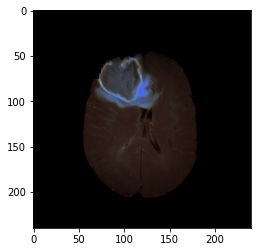

In [22]:
from tkinter.tix import COLUMN
from matplotlib.pyplot import colormaps
from pyrsistent import v


total_val_images = 1153

lam = '0.49'

for i in range(115, 116):
    with torch.no_grad():
        input_val  = val_data_tensor[i,2:,:,:].to(device)

        input_val = torch.unsqueeze(input_val, 0)

        weight_map_val = model(input_val)
        
        fused_val = weight_map_val*input_val[:,0:1,:,:] + (1-weight_map_val)*input_val[:,1:2,:,:]
        
        weight_map_val_norm = 2*weight_map_val

        weight_map_val_norm = (weight_map_val_norm - torch.min(weight_map_val_norm))/(torch.max(weight_map_val_norm) - torch.min(weight_map_val_norm))

        fused_val_norm = weight_map_val_norm*input_val[:,0:1,:,:] + (1-weight_map_val_norm)*input_val[:,1:2,:,:]

        weight_map_new = torch.mul(weight_map_val_norm, binary_mask_t1ce[i,:,:,:])

        fused_val_new = weight_map_new*input_val[:,0:1,:,:] + (1-weight_map_new)*input_val[:,1:2,:,:]

        lm_dict = {'weight_map': weight_map_val, 'weight_map_masked': weight_map_new, 'weight_map_norm' : weight_map_val_norm, 'fused_image': fused_val, 
        'fused_image_norm':fused_val_norm, 'fused_image_masked':fused_val_new}

        
        #torchvision.utils.save_image(weight_map_val, r'C:\Users\ishan\Desktop\Image Fusion\Fusion_R1/inference_p2/'+ lam + '/weight_map/weight_map_{}.png'.format(i))
        #torchvision.utils.save_image(weight_map_val_norm, r'C:\Users\ishan\Desktop\Image Fusion\Fusion_R1/inference_p2/'+ lam + '/weight_map_norm/weight_map_norm_{}.png'.format(i))
        #torchvision.utils.save_image(weight_map_new, r'C:\Users\ishan\Desktop\Image Fusion\Fusion_R1/inference_p2/'+ lam + '/weight_map_masked/weight_map_masked_{}.png'.format(i))
        
        
        #torchvision.utils.save_image(fused_val, r'C:\Users\ishan\Desktop\Image Fusion\Fusion_R1/inference_p2/'+ lam + '/fused_image/fused_image_{}.png'.format(i))
        #torchvision.utils.save_image(fused_val_norm, r'C:\Users\ishan\Desktop\Image Fusion\Fusion_R1/inference_p2/'+ lam + '/fused_image_norm/fused_image_norm_{}.png'.format(i))
        #torchvision.utils.save_image(fused_val_new, r'C:\Users\ishan\Desktop\Image Fusion\Fusion_R1/inference_p2/'+ lam + '/fused_image_masked/fused_image_masked_{}.png'.format(i))
        
        height = fused_val.shape[2]
        width = fused_val.shape[3]
        rgb = np.zeros((height, width,3))
        ones = np.zeros((height, width))
                
        rgb[:,:,0] = weight_map_new.cpu()
        rgb[:,:,1] = ones
        rgb[:,:,2] = fused_val.cpu()
        
        hsv = mpl.colors.rgb_to_hsv(rgb)
         
        #plt.imsave(r'C:/Users/ishan/Desktop/Image Fusion/Fusion_R1/Inference_p2/'+ lam + '/rgb/coupled_rgb_{}.png'.format(i), rgb)
     
        #plt.imsave(r'C:/Users/ishan/Desktop/Image Fusion/Fusion_R1/Inference_p2/'+ lam + '/hsv/coupled_hsv_{}.png'.format(i), hsv)

        clrmaps = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu','RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

        weight_map_new = weight_map_new.cpu().numpy()
        fused_val_new = (fused_val_new.cpu().numpy())
        
        
        #for cm in clrmaps:
           # plt.imsave(r'C:/Users/ishan/Desktop/Image Fusion/Fusion_R1/Inference_p2/' + lam + '/colormaps/weight_map/' + cm + '/colormap_{}.png'.format(i), weight_map_new[0,0,:,:], cmap = cm)
           # plt.imsave(r'C:/Users/ishan/Desktop/Image Fusion/Fusion_R1/Inference_p2/' + lam + '/colormaps/fused_image/' + cm + '/colormap_{}.png'.format(i), fused_val_new[0,0,:,:], cmap = cm)
            
        for cm in clrmaps[9:10]:
            my_cm = mpl.cm.get_cmap(cm)
            fused_val_new_cm = my_cm(fused_val_new[0,0,:,:])
            weight_map_new_cm = my_cm(weight_map_new[0,0,:,:])
            weight_map_new_cm = weight_map_new_cm[:,:,0:3]
            hsv_wm = mpl.colors.rgb_to_hsv(weight_map_new_cm)
            #plt.imshow(hsv_wm)
            hsv_wm_cross = hsv_wm
            hsv_wm_cross[:,:,2] = fused_val_new[0,0,:,:]
            plt.imshow(hsv_wm_cross)
            hsv_wm_mul = hsv_wm
            hsv_wm_mul[:,:,2] = hsv_wm[:,:,2]*fused_val_new[0,0,:,:]
            plt.imshow(hsv_wm_mul)
            weight_map_back = mpl.colors.hsv_to_rgb(hsv_wm_cross)
            plt.imshow(weight_map_back)
            # fig = plt.figure()
            # rows = 4
            # columns = 1
            # fig.add_subplot(rows, columns, 1)
            #plt.imshow(fused_val_new[0,0,:,:], cmap="gray")
            # plt.title("Fused_Image")
            # fig.add_subplot(rows, columns, 2)
            #plt.imshow(weight_map_new_cm)
            # plt.title("Weight_map_colormapped")
            # fig.add_subplot(rows, columns, 3)
            #plt.imshow(hsv_wm)
            # plt.title("Weight_map_hsv")
            # fig.add_subplot(rows, columns, 4)
            #plt.imshow(hsv_wm_cross)
            # plt.title("hsv_fused_value_channel")

            
            #rgb_cm = my_cm(rgb)
            #plt.imsave(r'rgb_cm.png', rgb_cm)
            # overlay_arr = np.zeros((height, width, 3))
            # ones = np.zeros((height, width))
            # overlay_arr[:,:,0] = weight_map_new_cm[:,:,0]
            # overlay_arr[:,:,1] = ones
            # overlay_arr[:,:,2] = fused_val_new_cm[:,:,1]
            #plt.imsave(r'C:/Users/ishan/Desktop/Image Fusion/Fusion_R1/Inference_p2/' + lam + '/colormaps/overlay/' + cm + '/overlay_{}.png'.format(i), overlay_arr)
            
            # plt.imshow(fused_val_new[0,0,:,:], cmap='gray')
            # plt.imshow(weight_map_new_cm, interpolation= 'nearest', alpha=0.9)
            # plt.axis('off')
            #plt.colorbar()
            #from PIL import Image
            #im1 = Image.fromarray(weight_map_new_cm)
            #im2 = Image.fromarray(fused_val_new[0,0,:,:])
            #new_image = Image.blend(weight_map_new_cm, fused_val_new[0,0,:,:], 0.5)
            #new_image.save("overlay.png","PNG")

        
            
        

    
        

       

In [15]:
hsv_wm_mul.shape

(240, 240)

In [ ]:
hsv_wm[:,:,2] = fused_val_new[0,0,:,:]

In [ ]:
try:
    from PIL import Image
except ImportError:
    import image

im1 = Image.open(r'C:\Users\ishan\Desktop\Image Fusion\Fusion_R1\inference_p2\0.49\colormaps\weight_map\RdGy\colormap_115.png')
im2 = Image.open(r'C:\Users\ishan\Desktop\Image Fusion\Fusion_R1\inference_p2\0.49\fused_image_masked\fused_image_masked_115.png')

new_im = Image.blend(im1, im2, 0.5)
new_im.save('overlay.png', 'PNG')

In [ ]:
 im = plt.imshow(fused_val_new[0,0,:,:], cmap='PiYG')
 cbar = plt.colorbar()
 cbar.set_label('Pixel values (0 to 1)')
 

In [ ]:
my_cm = mpl.cm.get_cmap('PiYG')
image = my_cm(fused_val_new[0,0,:,:])
plt.imshow(image)
cbar = plt.colorbar()
cbar.set_label('Pixel values (0 to 1)')


In [ ]:
plt.colormaps(fused_val_new[0,0,:,:], cmap='PiYG')